In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1,l1_l2,l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import HeUniform

from sklearn.utils import class_weight
from shutil import copy2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels

# from vis.utils import utils
from tensorflow.keras import activations 
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

### Preprocessing

In [4]:
num_classes = 15
img_rows, img_cols = 64,64
batch_size =32
train_data_dir ="/home/cvpia/felix_work/Neural_networks/assignment2/15-scene/train/"
validation_data_dir = "/home/cvpia/felix_work/Neural_networks/assignment2/15-scene/validation/"

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator()
#rescale=1./255)
validation_datagen = ImageDataGenerator()
 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 4458 images belonging to 15 classes.
Found 1156 images belonging to 15 classes.


In [5]:
model = Sequential()

# First CONV-ReLU Layer
model.add(Conv2D(39, (3, 3), padding = 'same', input_shape = (img_rows, img_cols,1),kernel_regularizer=l2(0.38),
                 kernel_initializer=HeUniform()))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

# Second CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

## 3rd conv-pool layer
model.add(Conv2D(256, (3, 3), padding="same",kernel_regularizer=l2(0.38), kernel_initializer=HeUniform()))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(621))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.0530))


# Final Dense Layer
model.add(Dense(num_classes,activation='softmax',name='Hafizzo'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 39)        390       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 39)        156       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 39)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 39)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 39)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        22528     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

In [6]:
checkpoint = ModelCheckpoint("cnn_scene_Reluv2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr=0.0001,momentum=0.9),
              metrics = ['accuracy'])


epochs = 100
import time
time_start=time.perf_counter()

history= model.fit_generator(   
    
    train_generator,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator)
elapsed_time=time.perf_counter()-time_start



Epoch 1/100


/home/cvpia/havugimanas/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/home/cvpia/havugimanas/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


140/140 [==============================] - 18s 128ms/step - loss: 66.5878 - accuracy: 0.3116 - val_loss: 19.7847 - val_accuracy: 0.3382

Epoch 00001: val_loss improved from inf to 19.78468, saving model to cnn_scene_Reluv2.h5
Epoch 2/100
140/140 [==============================] - 18s 127ms/step - loss: 14.9111 - accuracy: 0.4886 - val_loss: 11.5624 - val_accuracy: 0.2933

Epoch 00002: val_loss improved from 19.78468 to 11.56240, saving model to cnn_scene_Reluv2.h5
Epoch 3/100
140/140 [==============================] - 18s 127ms/step - loss: 8.3401 - accuracy: 0.5644 - val_loss: 9.2797 - val_accuracy: 0.1851

Epoch 00003: val_loss improved from 11.56240 to 9.27966, saving model to cnn_scene_Reluv2.h5
Epoch 4/100
140/140 [==============================] - 18s 126ms/step - loss: 4.7951 - accuracy: 0.6395 - val_loss: 10.8982 - val_accuracy: 0.1289

Epoch 00004: val_loss did not improve from 9.27966
Epoch 5/100
140/140 [==============================] - 18s 127ms/step - loss: 3.1741 - accur

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


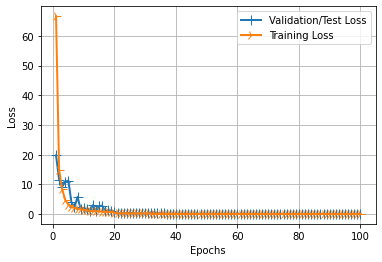

In [7]:
print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss.png', dpi = 1200)
plt.show()

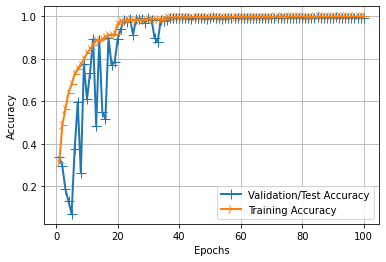

In [8]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('Accuracy.png', dpi = 1200)
plt.show()

### Evaluation